In [28]:
# TODO Currently accesses .pos files from local directory. Must change to download from Zenodo when available
# Zachary Katz
# zachary_katz@mines.edu
# August 2024

# Make and save the catalog of Whillans Stick Slip Events from .pos files

# Imports
import os

import src.Catalog.Catalog as Catalog
import logging

# %load_ext line_profiler

################################################################################
########################## User Defined Variables ##############################
# fmt: off

# Stations, Years, Data Path
dir = "/mnt/d/csrs_2024/all" 
stas = ["la01", "la02", "la03", "la04", "la05", "la06", "la07", "la08", "la09",
        "la10", "la11", "la12", "la13", "la14", "la15", "la16", "la17", "la18",
        "ws04", "ws05",
        "gz01", "gz02", "gz03", "gz04", "gz05", "gz06", "gz07", "gz08", "gz09",
        "gz10", "gz11", "gz12", "gz13", "gz14", "gz15", "gz16", "gz17", "gz18",
        "gz19", "gz20",
        "mg01", "mg02", "mg03", "mg04", "mg05", "mg06", "mg07",
        "slw1"
        ]
#year_arr = [["2007","2008","2009"],["2016","2017","2018","2019"]]
#year_arr = [["2007"],["2008"],["2009"],["2010"],["2011"],["2012"],['2013'],['2014'],['2015'],["2016"],["2017"],["2018"],["2019"]]
year_arr = [["2008"],["2009"],["2010"],["2011"],["2012"],['2013'],['2014'],['2015'],["2016"],["2017"],["2018"],["2019"]]

# Detection parameters
max_gap_len = 120 # Maximum gap length to interpolate [seconds]
window = 150 # Window size for least-squares averaging [minutes]
slide = 5 # Slide size for least-squares averaging [minutes]
active_stas = 2 # Minimum number of active stations needed for an event
cull_time = 30 # Remove catalog events lasting less than this time [minutes]
cull_dist = 0.1 # Remove catalog events with less than this distance [meters]
plot_bool = False # Flag to plot catalog
min_stas = 2 # Minimum number of stations needed for an event

# Log Level
# Currently implemented: ERROR, WARNING, INFO, DEBUG
# Each level also includes all levels above it.,
loglevel = "INFO" 


# fmt: on
########################## User Defined Variables ##############################
################################################################################

In [29]:
def set_log_level(loglevel: str) -> None:
    """Set logging level for the run

    Parameters
    ----------
    loglevel : str
        Logging level
    """
    FORMAT = "%(asctime)s %(name)s %(levelname)s: %(message)s"
    DATEFMT = "%Y-%m-%d %H:%M:%S"
    if loglevel == "ERROR":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.ERROR, force=True
        )
    elif loglevel == "WARNING":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.WARNING, force=True
        )
    elif loglevel == "INFO":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.INFO, force=True
        )
    elif loglevel == "DEBUG":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.DEBUG, force=True
        )

In [30]:
# Setup logger
set_log_level(loglevel)
logger = logging.getLogger(__name__)

# Convert window and slide to 15 second chunks
window = window * 60 / 15
slide = slide * 60 / 15

# Create Catalog
for years in year_arr:
    cats = []
    for sta in stas:
        interpolation_time, run = Catalog.set_interpolation_time(sta, years)
        if run:
            logger.info(f"Creating Dataframe for {sta}")
            cat = Catalog.Datastream(
                os.path.join(dir, sta), sta, years, interpolation_time
            )
            logger.info(f"Interpolating {sta}")
            if not cat.data.empty:
                cat.findgaps(max_gap_len)
                cats.append(cat)

    logger.info("Creating Catalog")
    picks = Catalog.Picks(cats)
    picks.lls_detection(window, slide)
    sorted_list = picks.on_off_list()
    no_data = picks.no_data_csv(min_stas, sorted_list)

    merged_df = picks.merge()
    merged = Catalog.Events(merged_df)
    threshold = merged.pick_events(sorted_list, active_stas=min_stas)

    catalog = merged.make_catalog(cull_time=30, cull_dist=0.1)
    save_dir = f"./{years[0]}_{years[-1]}Events_2stas"
    Catalog.save_catalog(catalog, save_dir)

    start_time_text = f"{years[0]}EventStartTime_2stas"
    folders = [f"./{years[0]}_{years[-1]}Events_2stas"]
    Catalog.event_start_time(folders, f"{start_time_text}")

2024-09-27 11:53:37 __main__ INFO: Creating Dataframe for la01
2024-09-27 11:53:37 __main__ INFO: Interpolating la01
2024-09-27 11:53:37 __main__ INFO: Creating Dataframe for la02
2024-09-27 11:53:48 __main__ INFO: Interpolating la02
2024-09-27 11:53:50 src.Catalog.Catalog INFO: 2008-05-04 04:35:00 2008-05-04 04:36:00 0 days 00:01:00
2024-09-27 11:53:51 src.Catalog.Catalog INFO: 2008-05-28 23:29:00 2008-05-28 23:30:30 0 days 00:01:30
2024-09-27 11:53:52 src.Catalog.Catalog INFO: 2008-05-29 23:24:00 2008-05-29 23:25:30 0 days 00:01:30
2024-09-27 11:53:54 src.Catalog.Catalog INFO: 2008-08-25 18:50:00 2008-08-25 18:52:00 0 days 00:02:00
2024-09-27 11:53:54 src.Catalog.Catalog INFO: 2008-08-25 18:56:00 2008-08-25 18:58:00 0 days 00:02:00
2024-09-27 11:53:54 src.Catalog.Catalog INFO: 2008-08-25 19:06:00 2008-08-25 19:08:00 0 days 00:02:00
2024-09-27 11:53:54 src.Catalog.Catalog INFO: 2008-08-26 15:31:30 2008-08-26 15:33:30 0 days 00:02:00
2024-09-27 11:53:55 src.Catalog.Catalog INFO: 2008-0

In [32]:
# Combine all start times into one text file

text_files = [f"{year[0]}EventStartTime_2stas.txt" for year in year_arr]

outfile = "AllEventStartTimes_2stas.txt"
# Read in all text files and remove 1st line
with open(outfile, "w") as out_file:
    out_file.write("EventStartTime\n")
    for file in text_files:
        with open(file, "r") as in_file:
            in_file.readline()
            for line in in_file:
                out_file.write(line)

In [33]:
# Combine all no data files into one text file

text_files = [f"{year[0]}-{year[0]}no_data_2sta.txt" for year in year_arr]

outfile = "no_data_2stas.txt"
# Read in all text files and remove 1st line
with open(outfile, "w") as out_file:
    out_file.write("start\tend\n")
    for file in text_files:
        with open(file, "r") as in_file:
            in_file.readline()
            for line in in_file:
                out_file.write(line)

Text(0, 0.5, 'Delta X')

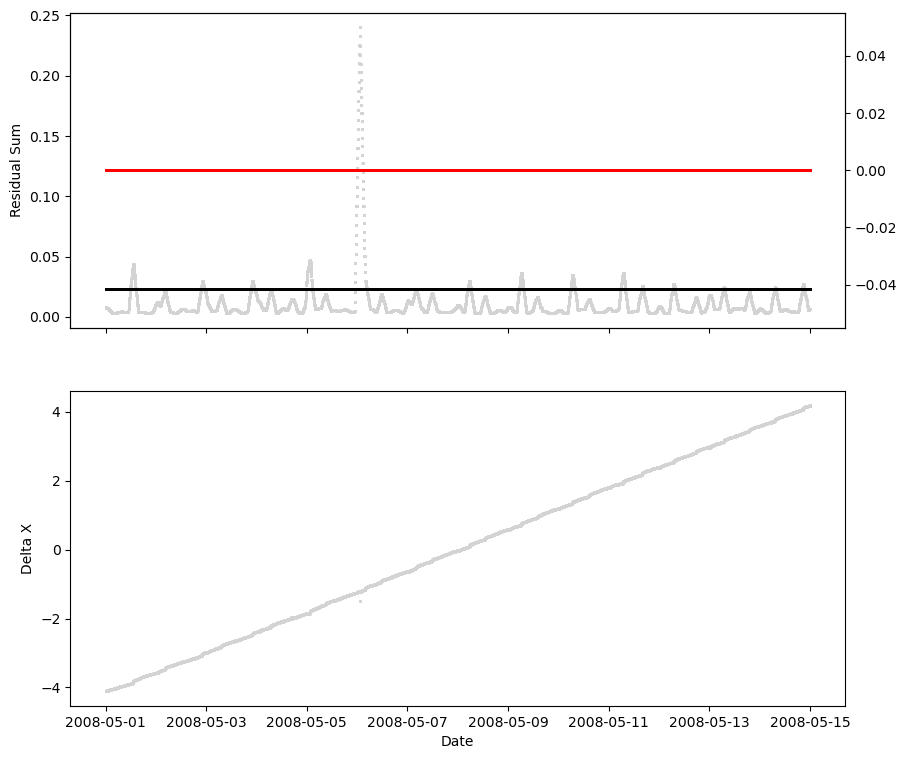

In [15]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax, ax2) = plt.subplots(2, figsize=(10, 9), sharex=True)
st_index = merged.merged[merged.merged["time"] == "2008-05-01T00:00:00"].index[0]
ed_index = merged.merged[merged.merged["time"] == "2008-05-15T00:00:00"].index[0]
ax.scatter(
    merged.merged["time"][st_index:ed_index],
    merged.merged["ressum"][st_index:ed_index],
    s=1,
    c="lightgray",
)
ax.scatter(
    merged.merged["time"][st_index:ed_index],
    merged.merged["sum_res_avg"][st_index:ed_index],
    s=1,
    c="black",
)
ax3 = ax.twinx()
ax3.scatter(
    merged.merged["time"][st_index:ed_index],
    merged.merged["event"][st_index:ed_index],
    s=1,
    c="red",
)

ax2.scatter(
    merged.merged["time"][st_index:ed_index],
    merged.merged["slw1x"][st_index:ed_index]
    - np.mean(merged.merged["slw1x"][st_index:ed_index]),
    s=1,
    c="lightgray",
)

ax2.scatter(
    merged.merged["time"][st_index:ed_index],
    merged.merged["la02x"][st_index:ed_index]
    - np.mean(merged.merged["la02x"][st_index:ed_index]),
    s=1,
    c="lightgray",
)


# ax2.scatter(merged.merged["time"][st_index:ed_index], merged.merged['la07x'][st_index:ed_index], s=1, c="black")
# Format x label
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax2.set_xlabel("Date")
ax.set_ylabel("Residual Sum")
ax2.set_ylabel("Delta X")

565
Error in callback <function _draw_all_if_interactive at 0x7f8a38fbfd80> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

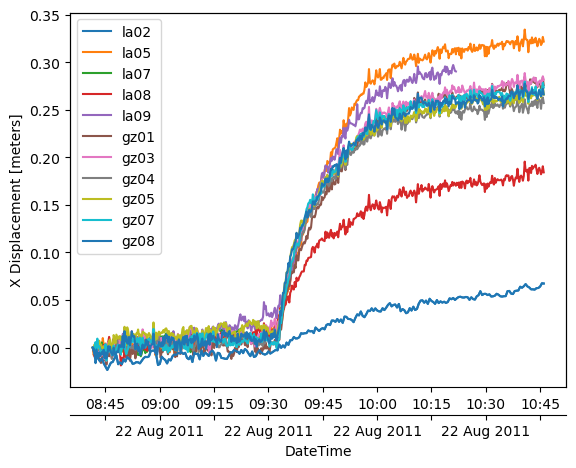

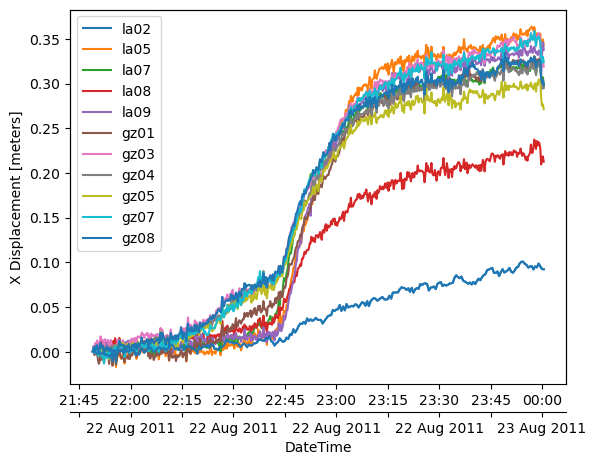

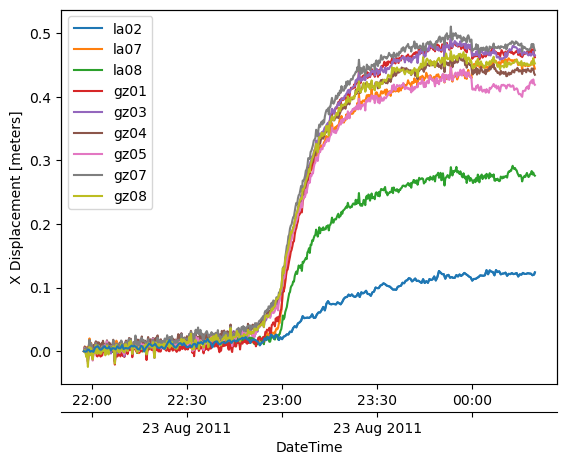

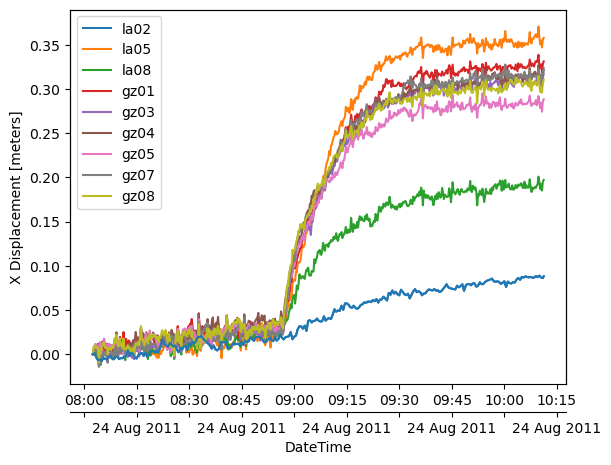

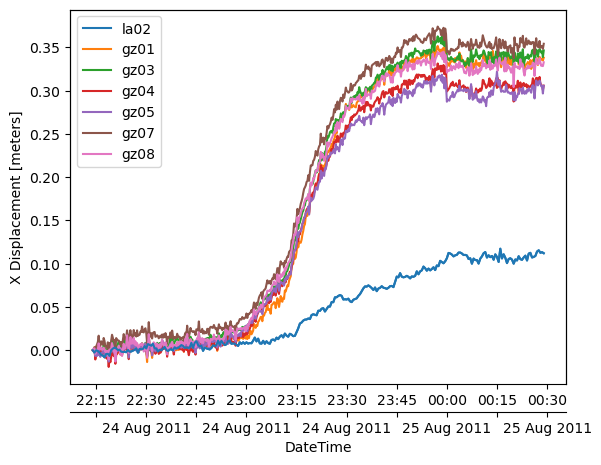

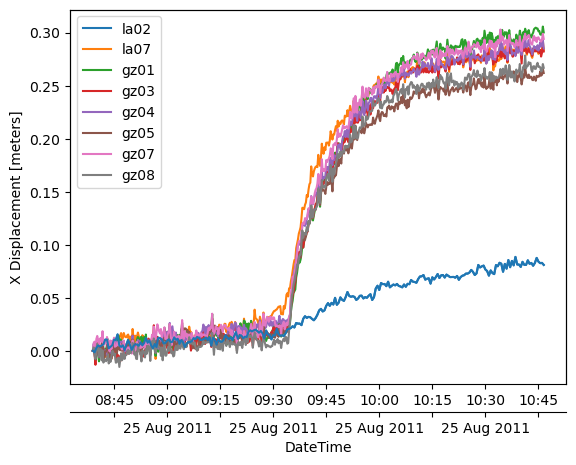

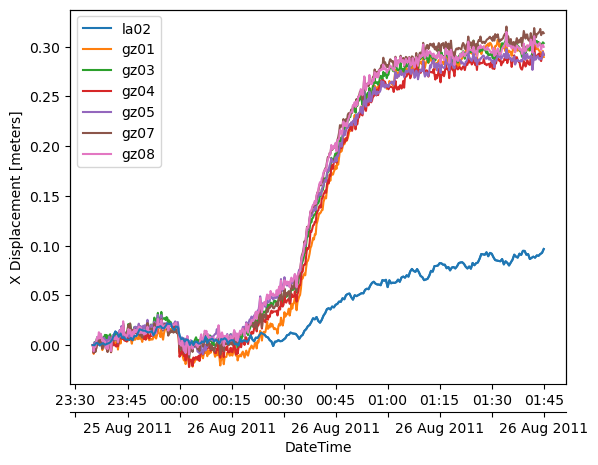

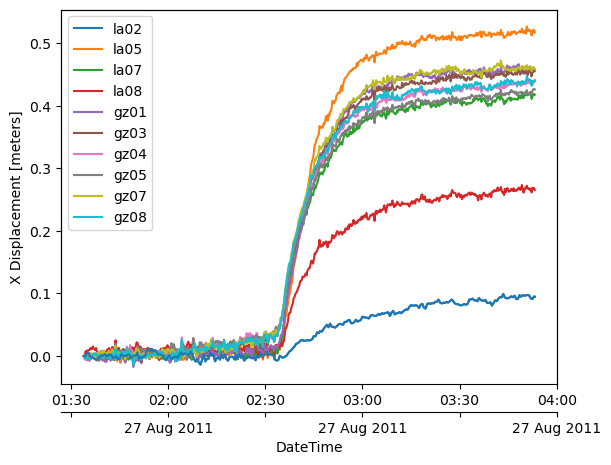

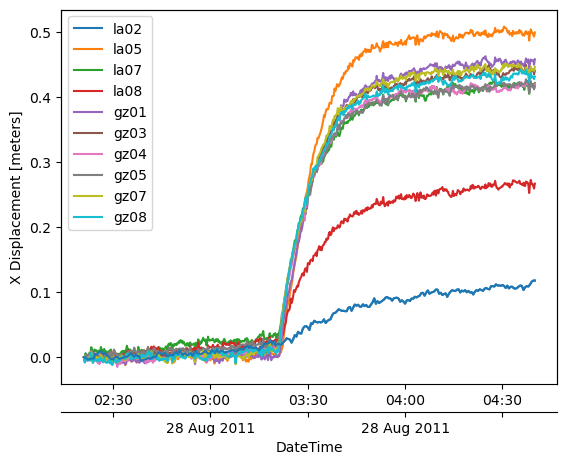

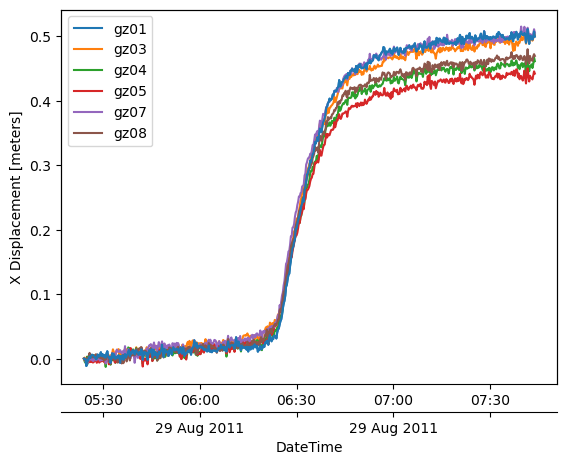

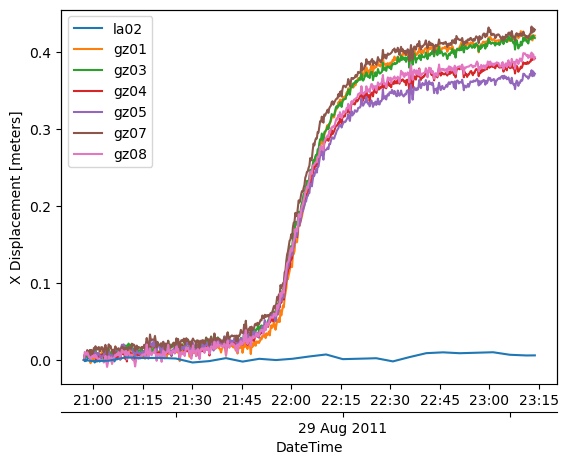

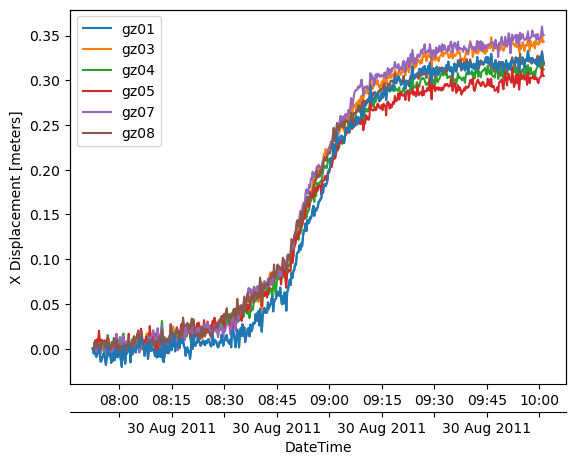

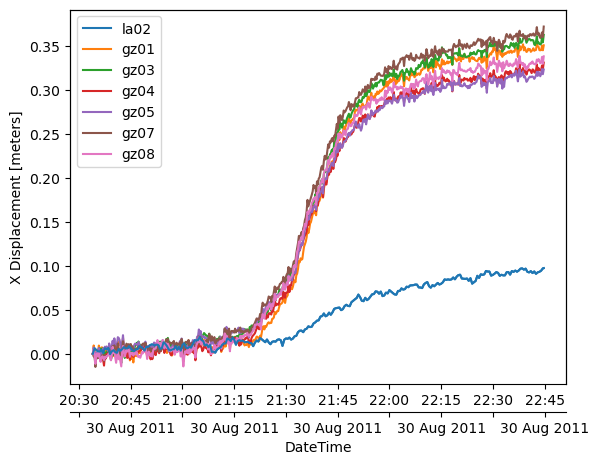

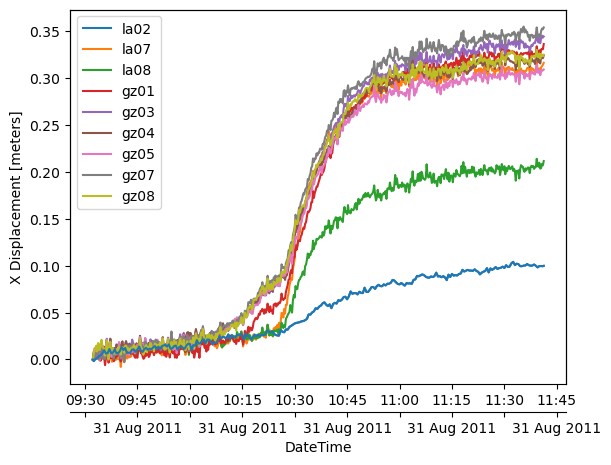

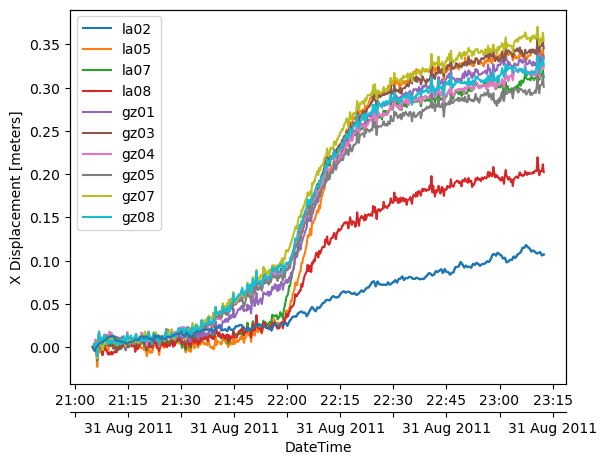

In [119]:
# Plot Example Events
print(len(catalog))
for event in catalog[365:380]:
    Catalog.plot_event(event)

In [ ]:
import matplotlib.pyplot as plt

fig, (ax, ax2) = plt.subplots(2, figsize=(10, 9), sharex=True)
st_index = merged.merged[merged.merged["time"] == "2011-09-21T12:00:00"].index[0]
ed_index = merged.merged[merged.merged["time"] == "2011-09-28T12:00:00"].index[0]
# ax.scatter(merged.merged['time'][st_index:ed_index], merged.merged['la05res'][st_index:ed_index],s=1,c='lightsteelblue')
# ax.scatter(merged.merged['time'][st_index:ed_index], merged.merged['la07res'][st_index:ed_index],s=1,c='darkorchid')
# ax.scatter(merged.merged['time'][st_index:ed_index], merged.merged['la08res'][st_index:ed_index],s=1,c='darkorange')
# ax.scatter(merged.merged['time'][st_index:ed_index], merged.merged['gz01res'][st_index:ed_index],s=1,c='darkgreen')
# ax.scatter(merged.merged['time'][st_index:ed_index], merged.merged['gz03res'][st_index:ed_index],s=1,c='darkred')

# ax.scatter(merged.merged['time'][st_index:ed_index], merged.merged['gz01res_avg'][st_index:ed_index],s=1,c='darkgreen')
# ax.scatter(merged.merged['time'][st_index:ed_index], merged.merged['gz03res_avg'][st_index:ed_index],s=1,c='darkred')
# ax.scatter(merged.merged['time'][st_index:ed_index], merged.merged['la05res_avg'][st_index:ed_index],s=1,c='lightsteelblue')
# ax.scatter(merged.merged['time'][st_index:ed_index], merged.merged['la07res_avg'][st_index:ed_index],s=1,c='darkorchid')
# ax.scatter(merged.merged['time'][st_index:ed_index], merged.merged['la08res_avg'][st_index:ed_index],s=1,c='darkorange')

sum_res_avg = np.nansum(
    merged.merged[
        ["la05res_avg", "la07res_avg", "la08res_avg", "gz01res_avg", "gz03res_avg"]
    ].iloc[st_index:ed_index],
    axis=1,
)

sum_res = np.nansum(
    merged.merged[["la05res", "la07res", "la08res", "gz01res", "gz03res"]].iloc[
        st_index:ed_index
    ],
    axis=1,
)
mean_res = np.nanmean(
    merged.merged[["la05res", "la07res", "la08res", "gz01res", "gz03res"]].iloc[
        st_index:ed_index
    ],
    axis=1,
)  # Nanmean skips nan
std_res = np.nanstd(
    merged.merged[["la05res", "la07res", "la08res", "gz01res", "gz03res"]].iloc[
        st_index:ed_index
    ],
    axis=1,
)  # Nanstd skips nan

ax.scatter(merged.merged["time"][st_index:ed_index], sum_res, s=1, c="lightgray")
ax.scatter(merged.merged["time"][st_index:ed_index], sum_res_avg, s=1, c="black")
merged.merged["sum_res_avg"] = sum_res_avg
merged.merged["sum_res"] = sum_res
# ax.scatter(merged.merged['time'][st_index:ed_index], mean_res,s=1,c='black')
# ax.scatter(merged.merged['time'][st_index:ed_index], std_res,s=1,c='black')

# ax2 = ax.twinx()
la05x = (
    merged.merged["la05x"][st_index:ed_index]
    - merged.merged["la05x"][st_index:ed_index].mean()
)
la07x = (
    merged.merged["la07x"][st_index:ed_index]
    - merged.merged["la07x"][st_index:ed_index].mean()
)
la08x = (
    merged.merged["la08x"][st_index:ed_index]
    - merged.merged["la08x"][st_index:ed_index].mean()
)
gz01x = (
    merged.merged["gz01x"][st_index:ed_index]
    - merged.merged["gz01x"][st_index:ed_index].mean()
)
gz03x = (
    merged.merged["gz03x"][st_index:ed_index]
    - merged.merged["gz03x"][st_index:ed_index].mean()
)

ax2.scatter(
    merged.merged["time"][st_index:ed_index], la05x, s=1, color="lightsteelblue"
)
ax2.scatter(merged.merged["time"][st_index:ed_index], la07x, s=1, color="darkorchid")
ax2.scatter(merged.merged["time"][st_index:ed_index], la08x, s=1, color="darkorange")
ax2.scatter(merged.merged["time"][st_index:ed_index], gz01x, s=1, color="darkgreen")
ax2.scatter(merged.merged["time"][st_index:ed_index], gz03x, s=1, color="darkred")
ax.set_xlim(merged.merged["time"][st_index], merged.merged["time"][ed_index])

ax.set_ylabel("Sliding Least Squares Residuals [m]")
ax2.set_ylabel("Displacement [m]")

ax3 = ax2.twinx()
ax3.scatter(
    merged.merged["time"][st_index:ed_index],
    merged.merged["event"][st_index:ed_index],
    s=1,
    c="black",
)